### Imports

In [203]:
from mpi4py import MPI
from petsc4py import PETSc

import numpy as np
from scipy.sparse import csr_matrix

import ufl
from basix.ufl import element, mixed_element
from dolfinx import fem, la, plot
from dolfinx.fem import (
  Constant,
  Function,
  dirichletbc,
  extract_function_spaces,
  form,
  functionspace,
  locate_dofs_topological,
)
from dolfinx.fem.petsc import (
  assemble_matrix_block, assemble_vector_block,
  assemble_matrix, assemble_vector
)
from dolfinx.io import XDMFFile
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from ufl import div, dx, grad, inner

import matplotlib.pyplot as plt

import tt
from tt import cross

from als_cross import als_cross

### Parameters

In [204]:
rng = np.random.default_rng()

# number of sinkers
n_sinker = 2
# sinker exponential decay rate
delta = rng.uniform(10, 200, n_sinker)
# size of sinker center
omega = 0.1
# driving field strength
beta = 10
# center of sinkers
# c = np.random.rand(n_sinker,2)
c = np.array([[0.2, 0.3],[0.6,0.7]])
# dynamic ratio of viscosity
DR = 100
mu_min = 1 / np.sqrt(DR)
mu_max = np.sqrt(DR)


def chi(x, centers, deltas):
  res = np.ones(x.shape[1])
  for i in range(n_sinker):
    res *= 1 - np.exp(-deltas[i] * np.square(np.maximum(0, np.linalg.norm(x[:2] - centers[i].reshape(-1,1), axis = 0) - 0.5 * omega)))
  
  return res

def viscosity_expr(x, centers=c, deltas=delta):
  """Viscosity field"""
  return (mu_max - mu_min) * (1 - chi(x, centers, deltas)) + mu_min

def f_expr(x, centers=c, deltas=delta):
  """Driving field"""
  return np.vstack([np.zeros(x.shape[1]), beta * (chi(x, centers, deltas) - 1)])

### FEM setup

In [205]:
# Create mesh
msh = create_rectangle(
    MPI.COMM_WORLD, [np.array([0, 0]), np.array([1, 1])], [32, 32], CellType.triangle
)

# Function to mark x = 0, x = 1, y = 0 and y = 1 (all boundary) 
def noslip_boundary(x):
    # return np.logical_or(
    #     np.logical_or(np.isclose(x[0], 0.0), np.isclose(x[0], 1.0)), 
    #     np.isclose(x[1], 0.0), np.isclose(x[1], 2.0)
    # )
    return np.full(x.shape[1], True)

P2 = element("Lagrange", msh.basix_cell(), 2, shape=(msh.geometry.dim,))
P1 = element("Lagrange", msh.basix_cell(), 1)
V, Q = functionspace(msh, P2), functionspace(msh, P1)

# No-slip condition on boundaries 
noslip = np.zeros(msh.geometry.dim, dtype=PETSc.ScalarType)  # type: ignore
facets = locate_entities_boundary(msh, 1, noslip_boundary)
bc0 = dirichletbc(noslip, locate_dofs_topological(V, 1, facets), V)

# Collect Dirichlet boundary conditions
bcs = [bc0]

# Define variational problem
(u, p) = ufl.TrialFunction(V), ufl.TrialFunction(Q)
(v, q) = ufl.TestFunction(V), ufl.TestFunction(Q)

Vf = functionspace(msh, element("Lagrange", msh.basix_cell(), 1, shape=(msh.geometry.dim,)))
f = fem.Function(Vf)
f.interpolate(f_expr)

mu = fem.Function(Q)
mu.interpolate(viscosity_expr)

a = form([[mu * inner(grad(u), grad(v)) * dx, inner(p, div(v)) * dx], [inner(div(u), q) * dx, None]])
a00 = form(mu * inner(grad(u), grad(v)) * dx)
L = form([inner(f, v) * dx, inner(Constant(msh, PETSc.ScalarType(0)), q) * dx])  # type: ignore
L0 = form(inner(f, v) * dx)

# preconditioner
a_p11 = form(inner(p, q) * dx)
a_p = [[a[0][0], None], [None, a_p11]]

### TT decomposition of coeff

In [221]:
cells, cell_types, coords = plot.vtk_mesh(Q)

Ny = np.array(n_sinker * [10])
Nx = coords.shape[0]

def mu_func(x):
  res = np.empty(x.shape[0])
  for i, xi in enumerate(x):
    d = (190 * xi[1:] / (Ny-1) + 10).reshape(-1,1)
    res[i] = viscosity_expr(coords[xi[0]].reshape(-1,1), deltas=d)[0]
  
  return res

# random init tensor
C_mu = tt.rand(np.array([Nx] + Ny.tolist()),r=10)
# compute TT approx using TT-cross
C_mu = tt.cross.rect_cross.cross(mu_func, C_mu, nswp=10, eps = 1e-8, kickrank=5)
C_mu = C_mu.round(1e-12)

print("mu TT ranks: ", C_mu.r)

Nx_f = f.x.array.shape[0]

def f_func(x):
  res = np.empty(x.shape[0])
  for i, xi in enumerate(x):
    d = (190 * xi[1:] / (Ny-1) + 10).reshape(-1,1)
    quot, rem = np.divmod(xi[0], 2)
    res[i] = f_expr(coords[quot].reshape(-1,1), deltas=d).squeeze()[rem]
  
  return res

# random init tensor
C_f = tt.rand(np.array([Nx_f] + Ny.tolist()),r=10)
# compute TT approx using TT-cross
C_f = tt.cross.rect_cross.cross(f_func, C_f, nswp=10, eps = 1e-8, kickrank=5)
C_f = C_f.round(1e-12)

print("f TT ranks: ", C_f.r)

# helper tensor that is constant 1
cores = [np.ones((1,1,1))]
for i in range(len(Ny)):
  cores += [np.ones((1,Ny[i],1))]

C_const = tt.vector.from_list(cores)

swp: 0/9 er_rel = 3.1e+00 er_abs = 3.5e+03 erank = 18.6 fun_eval: 35970
swp: 1/9 er_rel = 7.3e-03 er_abs = 8.4e+00 erank = 28.4 fun_eval: 99187
swp: 2/9 er_rel = 1.0e-04 er_abs = 1.2e-01 erank = 37.9 fun_eval: 194607
swp: 3/9 er_rel = 2.1e-06 er_abs = 2.4e-03 erank = 46.5 fun_eval: 323319
swp: 4/9 er_rel = 5.1e-08 er_abs = 5.9e-05 erank = 54.4 fun_eval: 485323
swp: 5/9 er_rel = 1.1e-09 er_abs = 1.3e-06 erank = 61.7 fun_eval: 680619
mu TT ranks:  [ 1 85 10  1]
swp: 0/9 er_rel = 4.6e+00 er_abs = 5.2e+03 erank = 20.1 fun_eval: 70818
swp: 1/9 er_rel = 1.4e-02 er_abs = 1.6e+01 erank = 31.0 fun_eval: 196308
swp: 2/9 er_rel = 5.9e-05 er_abs = 6.7e-02 erank = 42.0 fun_eval: 383404
swp: 3/9 er_rel = 1.9e-06 er_abs = 2.2e-03 erank = 52.2 fun_eval: 634284
swp: 4/9 er_rel = 7.9e-08 er_abs = 9.1e-05 erank = 61.7 fun_eval: 948948
swp: 5/9 er_rel = 7.3e-10 er_abs = 8.3e-07 erank = 70.8 fun_eval: 1327396
f TT ranks:  [ 1 84 10  1]


In [207]:
class stokes_PDE_fun:
  def __init__(self):
    # Create mesh
    self.msh = create_rectangle(
        MPI.COMM_WORLD, [np.array([0, 0]), np.array([1, 1])], [32, 32], CellType.triangle
    )

    # Function to mark x = 0, x = 1, y = 0 and y = 1 (all boundary) 
    def noslip_boundary(x):
        # return np.logical_or(
        #     np.logical_or(np.isclose(x[0], 0.0), np.isclose(x[0], 1.0)), 
        #     np.isclose(x[1], 0.0), np.isclose(x[1], 2.0)
        # )
        return np.full(x.shape[1], True)

    P2 = element("Lagrange", msh.basix_cell(), 2, shape=(msh.geometry.dim,))
    P1 = element("Lagrange", msh.basix_cell(), 1)
    self.V, self.Q = functionspace(msh, P2), functionspace(msh, P1)

    # No-slip condition on boundaries 
    noslip = np.zeros(msh.geometry.dim, dtype=PETSc.ScalarType)  # type: ignore
    facets = locate_entities_boundary(msh, 1, noslip_boundary)
    bc0 = dirichletbc(noslip, locate_dofs_topological(V, 1, facets), V)

    # Collect Dirichlet boundary conditions
    self.bcs = [bc0]

    # Define variational problem
    (u, p) = ufl.TrialFunction(V), ufl.TrialFunction(Q)
    (v, q) = ufl.TestFunction(V), ufl.TestFunction(Q)
    
    Vf = functionspace(msh, element("Lagrange", msh.basix_cell(), 1, shape=(msh.geometry.dim,)))
    self.f = fem.Function(Vf)
    # self.f.interpolate(f_expr)

    self.mu = fem.Function(Q)
    # self.mu.interpolate(viscosity_expr)

    self.a = form([[self.mu * inner(grad(u), grad(v)) * dx, inner(p, div(v)) * dx], [inner(div(u), q) * dx, None]])
    self.a00 = form(self.mu * inner(grad(u), grad(v)) * dx)
    self.L = form([inner(f, v) * dx, inner(Constant(msh, PETSc.ScalarType(0)), q) * dx])  # type: ignore
    self.L0 = form(inner(f, v) * dx)

    # precompute constant matrix part
    self.mu.interpolate(lambda x : np.zeros(x.shape[1]))
    self.f.interpolate(lambda x: np.zeros((2, x.shape[1])))

    A = assemble_matrix(a00, bcs=bcs)
    A.assemble()
    # A.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    ai, aj, av = A.getValuesCSR()
    self.A_const = csr_matrix((av, aj, ai))

    b0 = assemble_vector(self.L0)
    fem.petsc.apply_lifting(b0, [self.a00], bcs=[self.bcs])
    b0.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b0, self.bcs)
    self.b_const = b0.getArray()


  def matrix(self,coeff):
    if len(coeff) != 2:
      raise Exception(f"Wrong number of matrix components ({len(coeff)} != 2).")
    
    [num_coeff, nx, I] = np.shape(coeff[0])
    mu_dofs = coeff[0][0,:,:]
    A0 = []
    for i in range(I):
      for k in range(self.mu.x.array.shape[0]):
        self.mu.x.array[k] = mu_dofs[k,i]
        
      A = assemble_matrix(self.a00, bcs=bcs)
      A.assemble()
      ai, aj, av = A.getValuesCSR()
      A0.append(csr_matrix((av, aj, ai)) - self.A_const)
    
    [num_coeff, nx, I] = np.shape(coeff[1])
    A1 = []
    for i in range(I):
      A1.append(self.A_const)
    
    return [A0, A1]
  
  def rhs(self, coeff):
    if len(coeff) != 2:
      raise Exception(f"Wrong number of rhs components ({len(coeff)} != 2).")
    
    [num_coeff, nx, I] = np.shape(coeff[0])
    f_dofs = coeff[0][0,:,:]
    b0 = []
    for i in range(I):
      for k in range(self.f.x.array.shape[0]):
        self.f.x.array[k] = f_dofs[k,i]
      
      b = assemble_vector(self.L0)
      fem.petsc.apply_lifting(b, [self.a00], bcs=[self.bcs])
      b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
      fem.petsc.set_bc(b, self.bcs)
      b0.append((b.getArray() - self.b_const).reshape(-1,1))
    
    [num_coeff, nx, I] = np.shape(coeff[1])
    b1 = []
    for i in range(I):
      b1.append(self.b_const.reshape(-1,1))
    
    return [b0, b1]
  
  def solve(self, coeff):

    [num_coeff, nx, I] = np.shape(coeff[0][0])
    
    U = []

    for i in range(I):
      for k in range(self.mu.x.array.shape[0]):
        self.mu.x.array[k] = coeff[0][0][0,k,i]
      for k in range(self.f.x.array.shape[0]):
        self.f.x.array[k] = coeff[1][0][0,k,i]

      U.append(self.solve_internal().reshape((-1,1)))
    
    return U

  def solve_internal(self):
    # Assemble nested matrix operators
    A = fem.petsc.assemble_matrix_nest(self.a, bcs=self.bcs)
    A.assemble()

    # Assemble right-hand side vector
    b = fem.petsc.assemble_vector_nest(self.L)

    # Modify ('lift') the RHS for Dirichlet boundary conditions
    fem.petsc.apply_lifting_nest(b, self.a, bcs=self.bcs)

    # Sum contributions for vector entries that are share across
    # parallel processes
    for b_sub in b.getNestSubVecs():
        b_sub.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    # Set Dirichlet boundary condition values in the RHS vector
    bcs0 = fem.bcs_by_block(extract_function_spaces(self.L), self.bcs)
    fem.petsc.set_bc_nest(b, bcs0)

    # The pressure field is determined only up to a constant. We supply
    # a vector that spans the nullspace to the solver, and any component
    # of the solution in this direction will be eliminated during the
    # solution process.
    null_vec = fem.petsc.create_vector_nest(self.L)

    # Set velocity part to zero and the pressure part to a non-zero
    # constant
    null_vecs = null_vec.getNestSubVecs()
    null_vecs[0].set(0.0), null_vecs[1].set(1.0)

    # Normalize the vector that spans the nullspace, create a nullspace
    # object, and attach it to the matrix
    null_vec.normalize()
    nsp = PETSc.NullSpace().create(vectors=[null_vec])
    assert nsp.test(A)
    A.setNullSpace(nsp)

    # Create a solver
    ksp = PETSc.KSP().create(msh.comm)
    ksp.setOperators(A)
    ksp.setType("preonly")
    
    # Set the solver type to MUMPS (LU solver) and configure MUMPS to
    # handle pressure nullspace
    pc = ksp.getPC()
    pc.setType("lu")
    pc.setFactorSolverType("mumps")
    try:
        pc.setFactorSetUpSolverType()
    except PETSc.Error as e:
        if e.ierr == 92:
            print("The required PETSc solver/preconditioner is not available. Exiting.")
            print(e)
            exit(0)
        else:
            raise e
    pc.getFactorMatrix().setMumpsIcntl(icntl=24, ival=1)  # For pressure nullspace
    pc.getFactorMatrix().setMumpsIcntl(icntl=25, ival=0)  # For pressure nullspace

    # Create finite element {py:class}`Function <dolfinx.fem.Function>`s
    # for the velocity (on the space `V`) and for the pressure (on the
    # space `Q`). The vectors for `u` and `p` are combined to form a
    # nested vector and the system is solved.
    u, p = Function(self.V), Function(self.Q)
    x = PETSc.Vec().createNest([la.create_petsc_vector_wrap(u.x), la.create_petsc_vector_wrap(p.x)])
    ksp.solve(b, x)

    return np.array(u.x.array)

### Run ALS cross

In [267]:
PDE_fun = stokes_PDE_fun()

test = als_cross(
  [C_mu, C_const],
  [C_f, C_const],
  PDE_fun,
  1e-8,
  random_init=15,
  kickrank=5
  )

test.iterate(3)
print(test.get_stats())

u = test.get_tensor()

print('Ranks', u.r)

= swp=1 core 0, max_dx=1.000e+00, max_rank = 15
= swp=1 core 1>, dx=1.000e+00, rank = [19, 9]
= swp=1 fwd finish, max_dx=1.000e+00, max_rank = 19
= swp=2 core <2, dx=0.000e+00, rank = [10, 1]
= swp=2 core <1, dx=7.152e-05, rank = [24, 10]
= swp=3 core 0, max_dx=2.308e-02, max_rank = 24
= swp=3 core 1>, dx=1.363e-02, rank = [29, 11]
= swp=3 fwd finish, max_dx=1.363e-02, max_rank = 29
{'t_solve': 2.891682423010934, 't_project': 0.1732279519783333, 'n_PDE_eval': 39}
Ranks [ 1 29 11  1]


relative l2 error: 1.82e-02


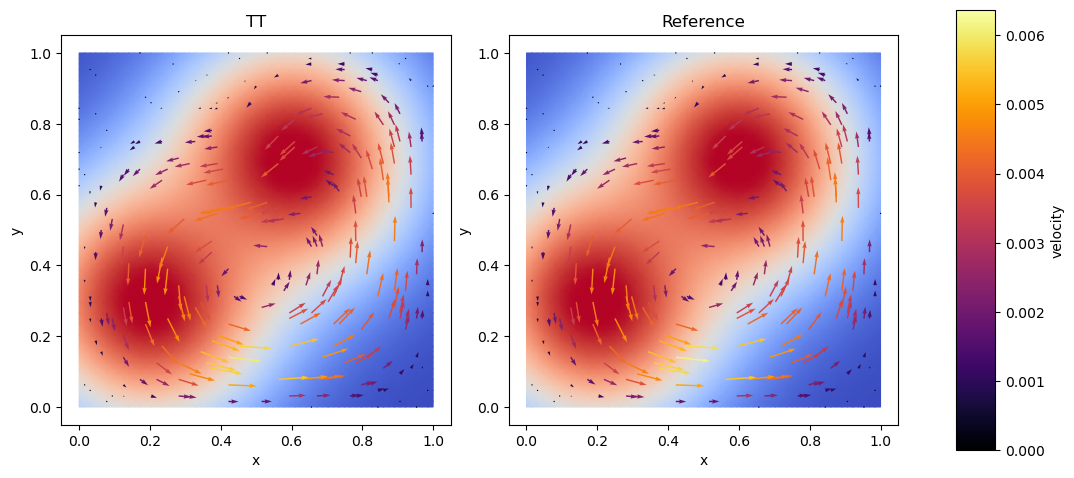

In [268]:
cells, cell_types, x = plot.vtk_mesh(V)
N = x.shape[0]

y = rng.integers(0, Ny)

fig, axs = plt.subplots(1,3, width_ratios=(1,1,0.1), figsize=(10,5))
fig.tight_layout()

d = (190 * y / (Ny-1) + 10).reshape(-1,1)
viscosity = viscosity_expr(x.T, deltas=d)

for ax in axs[:-1]:
  ax.tripcolor(x.T[0], x.T[1], viscosity,cmap='coolwarm', shading='gouraud')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_aspect('equal')

# random decimate points
rng = np.random.default_rng()
mask = rng.uniform(size = N) < (250 / N)

# TT approx
u_vec = np.empty((N,2))
for i in range(N):
  u_vec[i, 0] = u[np.concatenate([[2*i], y])]
  u_vec[i, 1] = u[np.concatenate([[2*i+1], y])]

# reference
PDE_fun = stokes_PDE_fun()
u_ref = PDE_fun.solve(
  [[C_mu[:, y[0], y[1]].full().reshape(1,-1,1), np.ones((1,1,1))],
  [C_f[:, y[0], y[1]].full().reshape(1,-1,1), np.ones((1,1,1))]]
)
u_ref = u_ref[0].reshape(N, V.dofmap.index_map_bs)

u_max = max(np.max(np.linalg.norm(u_vec, axis=1)), np.max(np.linalg.norm(u_ref, axis=1)))

velocity = axs[0].quiver(
  x[mask,0] , x[mask,1], u_vec[mask,0,], u_vec[mask,1], np.linalg.norm(u_vec[mask], axis=1),
  clim=(0,u_max), cmap='inferno')
axs[0].set_title('TT')

velocity = axs[1].quiver(
  x[mask,0] , x[mask,1], u_ref[mask,0,], u_ref[mask,1], np.linalg.norm(u_ref[mask], axis=1), 
  clim=(0,u_max), cmap='inferno')
axs[1].set_title('Reference')

cbar = fig.colorbar(velocity, ax=axs[1], cax=axs[2],)
cbar.set_label('velocity')


print(f'relative l2 error: {np.linalg.norm(u_vec-u_ref)/ np.linalg.norm(u_ref):.2e}')

In [269]:
MC_N = 100

err_acc = 0
norm_acc = 0

for n in range(MC_N):
  y = rng.integers(0, Ny)

  u_vec = np.empty((N,2))
  for i in range(N):
    u_vec[i, 0] = u[np.concatenate([[2*i], y])]
    u_vec[i, 1] = u[np.concatenate([[2*i+1], y])]

  u_ref = PDE_fun.solve(
    [[C_mu[:, y[0], y[1]].full().reshape(1,-1,1), np.ones((1,1,1))],
    [C_f[:, y[0], y[1]].full().reshape(1,-1,1), np.ones((1,1,1))]]
  )
  u_ref = u_ref[0].reshape(N, V.dofmap.index_map_bs)

  err = u_vec - u_ref
  err_acc += np.sum(np.square(err))

  norm_acc += np.sum(np.square(u_ref))

print(f'rel. RMS l2 error: {np.sqrt(err_acc / norm_acc):.2e}')

rel. RMS l2 error: 8.88e-03


In [270]:
from scipy.interpolate import BarycentricInterpolator

class eval_collocation:
  def __init__(self, tt_tensor):
    self.cores = tt.vector.to_list(tt_tensor)
    self.r = tt_tensor.r
    self.n = tt_tensor.n[1:]
    
    self.xpoints = []
    for n_i in self.n:
      self.xpoints.append(190 * (0.5 * np.polynomial.legendre.leggauss(n_i)[0] + 0.5) + 10)

    self.polys = []
    for i in range(len(self.n)):
      polys_i = []
      z = np.zeros(self.n[i])
      z[0] = 1
      for k in range(self.n[i]):
        polys_i.append(BarycentricInterpolator(self.xpoints[i], z.copy()))
        # polys_i.append(P.fit(self.xpoints[i], z, self.n[i]-1))
        if k < self.n[i] - 1:
          z[k+1] = 1
          z[k] = 0
      
      self.polys.append(polys_i)

  def __call__(self, y):
    res = np.ones((1,1))
    for i in reversed(range(len(self.n))):
      weight = np.empty((1,self.n[i],1))
      for k in range(self.n[i]):
        weight[0,k,0] = self.polys[i][k](y[i])

      res = np.sum(self.cores[i+1] * weight, axis = 1).reshape(-1, self.r[i+2]) @ res.reshape(self.r[i+2], -1)

    return (self.cores[0].reshape(-1, self.r[1]) @ res.reshape(self.r[1], -1)).flatten()

deltas: [166.94 107.84]
relative l2 error: 4.86e-02


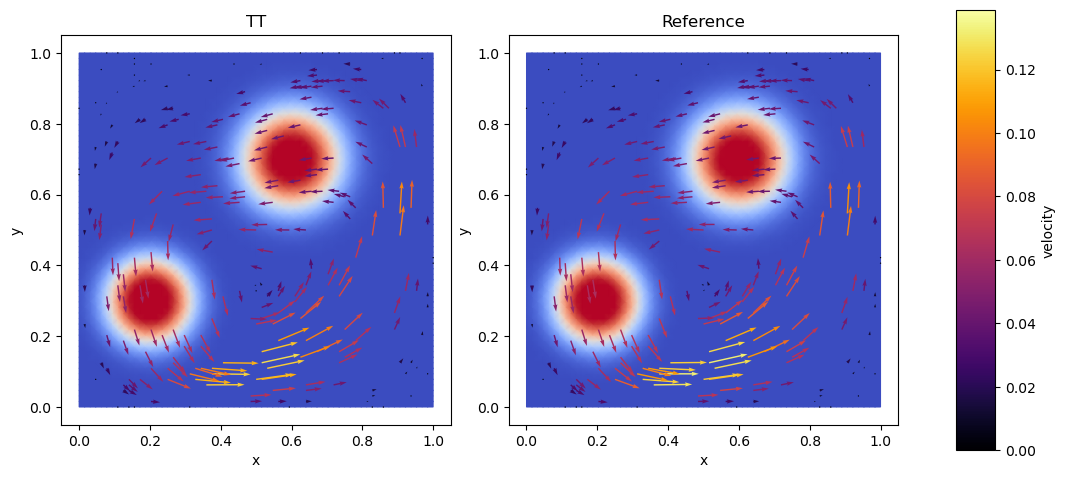

In [278]:
cells, cell_types, x = plot.vtk_mesh(V)
N = x.shape[0]

y = rng.uniform(10, 200, n_sinker)
print('deltas:', y.round(2))

fig, axs = plt.subplots(1,3, width_ratios=(1,1,0.1), figsize=(10,5))
fig.tight_layout()

viscosity = viscosity_expr(x.T, deltas=y.reshape(-1,1))

for ax in axs[:-1]:
  ax.tripcolor(x.T[0], x.T[1], viscosity,cmap='coolwarm', shading='gouraud')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_aspect('equal')

# random decimate points
rng = np.random.default_rng()
mask = rng.uniform(size = N) < (250 / N)

# TT approx with collocation
u_coll = eval_collocation(u)(y).reshape(N,2)

# reference
PDE_fun.f.interpolate(lambda x : f_expr(x, deltas=y))
PDE_fun.mu.interpolate(lambda x : viscosity_expr(x, deltas=y))
u_ref = PDE_fun.solve_internal().reshape(N,2)

u_max = max(np.max(np.linalg.norm(u_coll, axis=1)), np.max(np.linalg.norm(u_ref, axis=1)))

velocity = axs[0].quiver(
  x[mask,0] , x[mask,1], u_coll[mask,0,], u_coll[mask,1], np.linalg.norm(u_coll[mask], axis=1),
  clim=(0,u_max), cmap='inferno')
axs[0].set_title('TT')

velocity = axs[1].quiver(
  x[mask,0] , x[mask,1], u_ref[mask,0,], u_ref[mask,1], np.linalg.norm(u_ref[mask], axis=1), 
  clim=(0,u_max), cmap='inferno')
axs[1].set_title('Reference')

cbar = fig.colorbar(velocity, ax=axs[1], cax=axs[2],)
cbar.set_label('velocity')


print(f'relative l2 error: {np.linalg.norm(u_coll-u_ref)/ np.linalg.norm(u_ref):.2e}')

In [272]:
MC_N = 100

err_acc = 0
norm_acc = 0

for n in range(MC_N):
  y = rng.uniform(10, 200, n_sinker)

  u_coll = eval_collocation(u)(y).reshape(N,2)

  PDE_fun.f.interpolate(lambda x : f_expr(x, deltas=y))
  PDE_fun.mu.interpolate(lambda x : viscosity_expr(x, deltas=y))
  u_ref = PDE_fun.solve_internal().reshape(N,2)

  err = u_coll - u_ref
  err_acc += np.sum(np.square(err))

  norm_acc += np.sum(np.square(u_ref))

print(f'rel. RMS l2 error: {np.sqrt(err_acc / norm_acc):.2e}')

rel. RMS l2 error: 8.91e-02
